# SETUP

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#imports
import os 
import pickle
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

#tensorflow
import tensorflow as tf
from keras.layers import Dense, LSTM, Bidirectional, RNN
from keras.layers.embeddings import Embedding
from keras.models import Sequential

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
DATA_PATH = '/content/drive/My Drive/Research/Deeplearning-in-IoT-systems/PP_Data/'

In [ ]:
!nvidia-smi

Fri Sep 18 05:29:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# JS to keep Colab running
`
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
`



# LOAD DATA

In [ ]:
def getData(datasetName):
    X = np.load(f"{DATA_PATH}{datasetName}_X.npy", allow_pickle=True)
    Y = np.load(f"{DATA_PATH}{datasetName}_Y.npy", allow_pickle=True)
    enc_dec = np.load(f"{DATA_PATH}/{datasetName}_ENCDEC.npy", allow_pickle=True)
    return X, Y, enc_dec

In [ ]:
X, Y, (idx2act, idx2obs, act2idx, obs2idx) = getData('cairo')

# EDA

In [ ]:
i = [1, 3, 4 ,5 ]
print('Example of input')
print('-'*40)
print()
for idx in i:
  print(f"sequence of sensor activations: {X[idx]}")
  print(f"activity: {Y[idx]}")
  print()

Example of input
----------------------------------------

sequence of sensor activations: [ 0  0  0 ...  9 16  8]
activity: 5

sequence of sensor activations: [ 0  0  0 ... 46 47 46]
activity: 6

sequence of sensor activations: [ 0  0  0 ... 43 42 68]
activity: 2

sequence of sensor activations: [ 0  0  0 ... 18 27 26]
activity: 6



[[Text(0, 0, 'Eat'),
  Text(0, 0, 'Leave_Home'),
  Text(0, 0, 'Other'),
  Text(0, 0, 'Sleep'),
  Text(0, 0, 'Take_medicine'),
  Text(0, 0, 'Use Toiltet'),
  Text(0, 0, 'Wake'),
  Text(0, 0, 'Work')],
 Text(0.5, 1.0, 'Activity distribution of cairo dataset')]

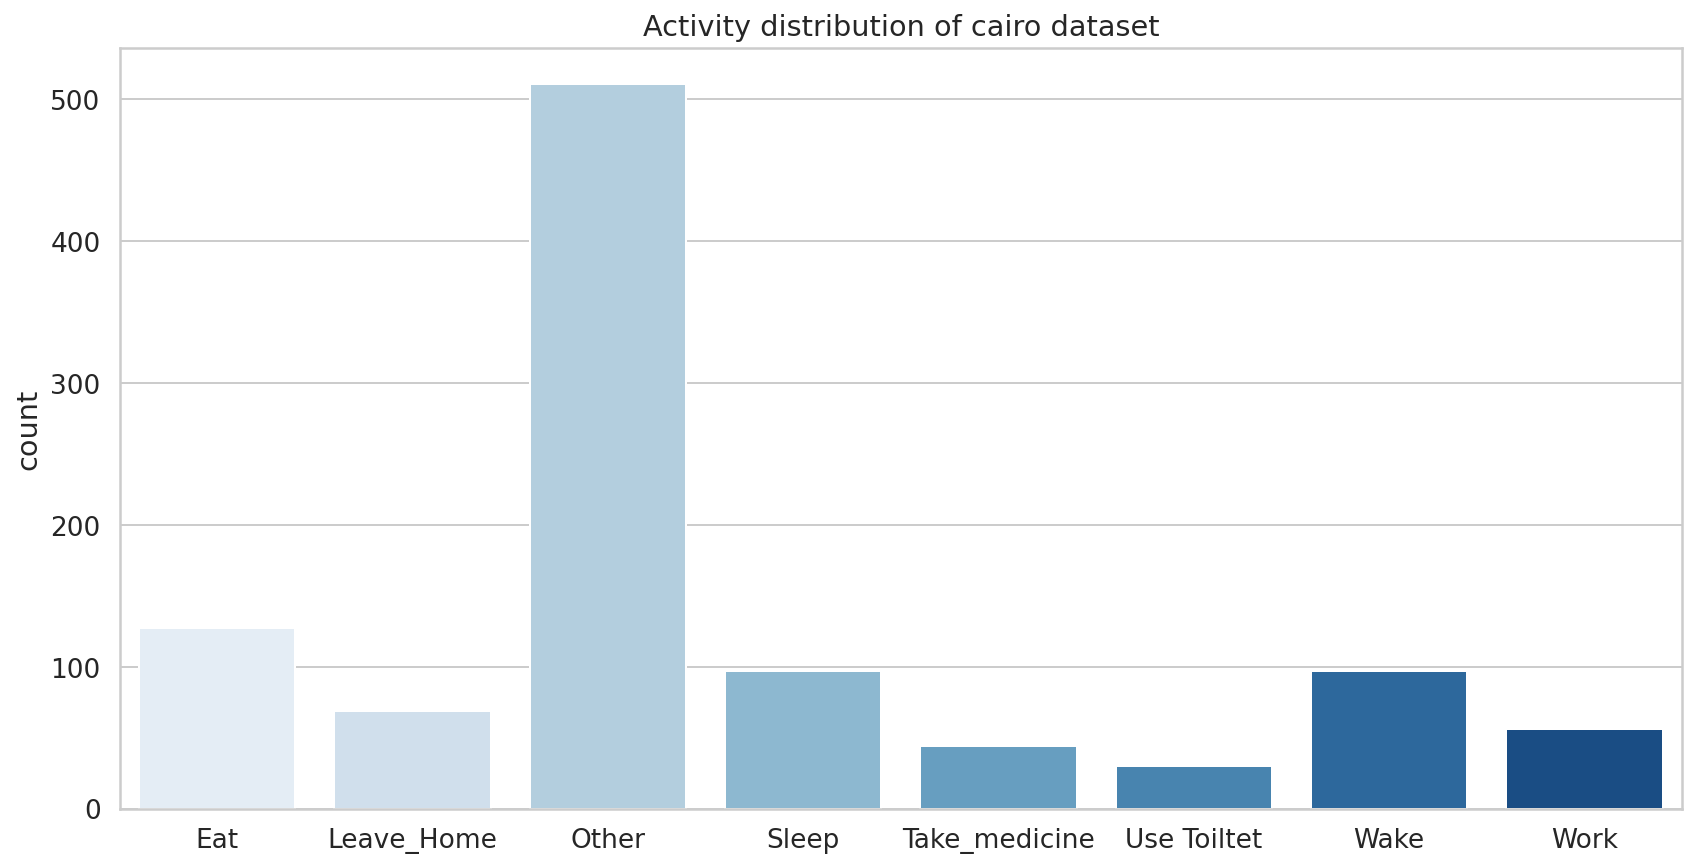

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
sns.countplot(Y, ax=ax, palette=sns.color_palette('Blues', 8))
ax.set(xticklabels=idx2act, title = "Activity distribution of cairo dataset")

# TEST DATA SPLIT

In [ ]:
split_point = int(0.9 * len(X))
X_train = X[:split_point]
Y_train = Y[:split_point]
X_test = X[split_point:]
Y_test = Y[split_point:]

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Train set size: 927
Test set size: 104


# MODEL ARCH

In [ ]:
# biLSTM 
def get_biLSTM(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER):
  model = Sequential(name='biLSTM')
  model.add(Embedding(INPUT_DIM, N_HIDDEN, input_length=MAX_LENGTH, mask_zero=True))
  model.add(Bidirectional(LSTM(N_HIDDEN)))
  model.add(Dense(NO_ACTIVITIES, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
INPUT_DIM = len(set(obs2idx.values()))+1
NO_ACTIVITIES = len(np.unique(Y))
MAX_LENGTH = 2000
N_HIDDEN = 64
OPTIMIZER = 'adam'
EPOCHS = 50

In [ ]:
model = get_biLSTM(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER)

Model: "biLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 64)          6592      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 73,672
Trainable params: 73,672
Non-trainable params: 0
_________________________________________________________________


In [ ]:
!pwd

/content


In [ ]:
# setup-settings:
config = {
    "name" : model.name,
    "epochs" : EPOCHS,
    "n_hidden" : N_HIDDEN,
    "input_dim" : INPUT_DIM,
    "opt": OPTIMIZER,
    "summary": model.get_config()
}
with open('config.json', 'w') as fp:
    json.dump(config, fp)

# Training

In [ ]:
X_np = np.array(X_train, dtype=np.int32)
Y_np = np.array(Y_train, dtype=np.int32)

In [ ]:
X_tensor = tf.convert_to_tensor(X_np, dtype=tf.float32)
Y_tensor = tf.convert_to_tensor(Y_np, dtype=tf.float32)

In [ ]:
save_as = "biLSTM-50ep-exp2"
filepath = f"/content/drive/My Drive/Research/Deeplearning-in-IoT-systems/Experiments/Models/{save_as}.h5"
saveModel = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', save_best_only=True, 
    save_weights_only=False, mode='auto', save_freq='epoch', options=None)

In [ ]:
history = model.fit(X_tensor, Y_tensor, validation_split=0.2, batch_size=64, verbose=1, epochs=EPOCHS, callbacks=[saveModel])

Epoch 1/50
12/12 [==============================] - 96s 8s/step - loss: 2.0098 - accuracy: 0.4467 - val_loss: 1.8629 - val_accuracy: 0.5000
Epoch 2/50
12/12 [==============================] - 94s 8s/step - loss: 1.6085 - accuracy: 0.4953 - val_loss: 1.4815 - val_accuracy: 0.5000
Epoch 3/50
12/12 [==============================] - 96s 8s/step - loss: 1.3275 - accuracy: 0.5074 - val_loss: 1.2502 - val_accuracy: 0.5860
Epoch 4/50
12/12 [==============================] - 96s 8s/step - loss: 1.0770 - accuracy: 0.6343 - val_loss: 1.0859 - val_accuracy: 0.6882
Epoch 5/50
12/12 [==============================] - 94s 8s/step - loss: 0.8865 - accuracy: 0.7179 - val_loss: 0.9509 - val_accuracy: 0.7204
Epoch 6/50
12/12 [==============================] - 93s 8s/step - loss: 0.8185 - accuracy: 0.7368 - val_loss: 0.8394 - val_accuracy: 0.7258
Epoch 7/50
12/12 [==============================] - 94s 8s/step - loss: 0.7371 - accuracy: 0.7868 - val_loss: 0.8155 - val_accuracy: 0.7258
Epoch 8/50
12/12 [==

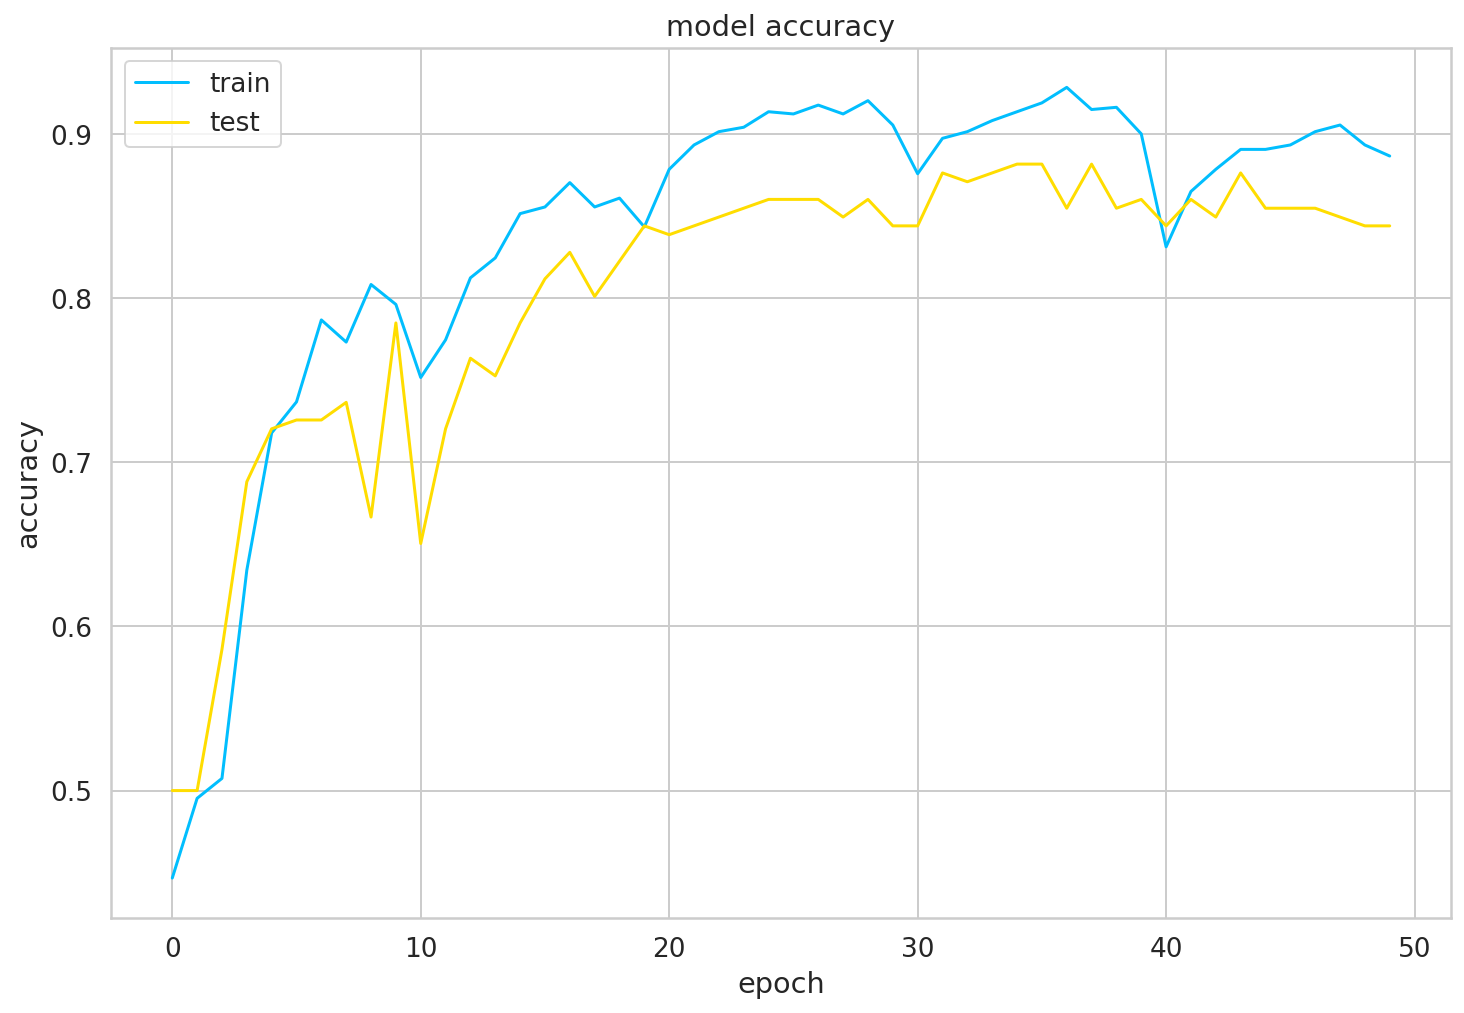

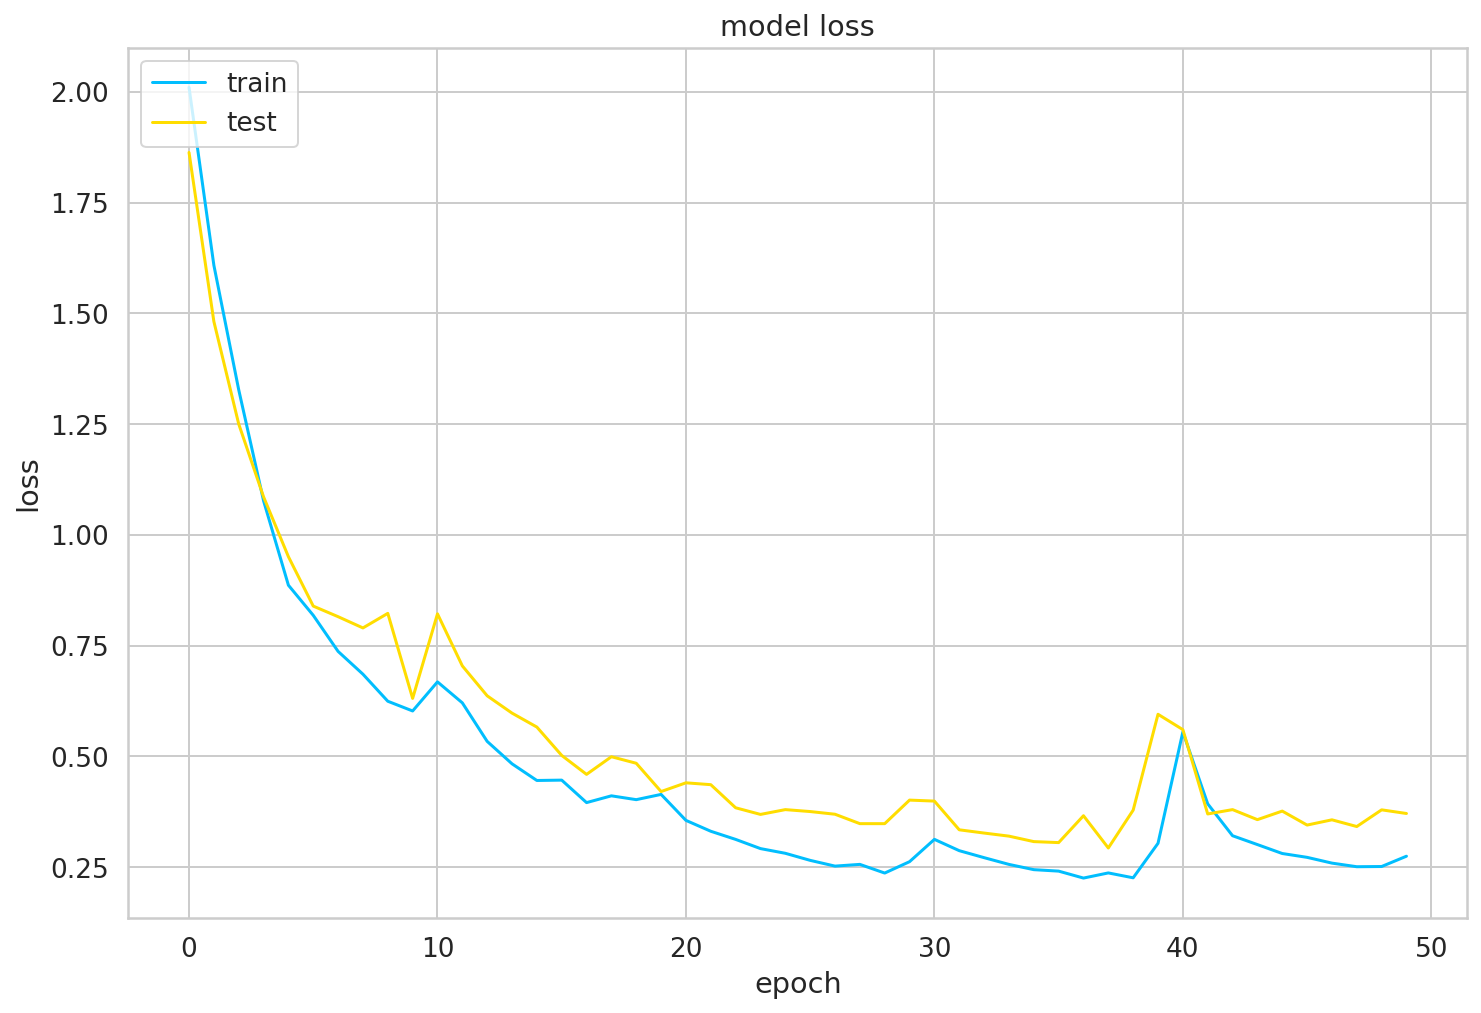

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
def get_class_acc(X_test, Y_test, model, idx2act):
  preds = np.array(np.argmax(model.predict(X_test), axis=-1), dtype=np.int32)
  targets = np.array(Y_test, dtype=np.int32)
  correct = {}
  total = {}
  for i in range(len(idx2act)):
    correct[i] = 1 
    total[i] = 1
  for i, pred in enumerate(preds):
    if pred == targets[i]:
      correct[pred] +=1
    total[pred]+=1
  
  for i, act in enumerate(idx2act):
    print(f"{act} : {correct[i]}/{total[i]}  [{round(correct[i]/total[i]*100,2)} %]")

In [ ]:
get_class_acc(X_tensor, Y_tensor, model, idx2act)

Eat : 106/159  [66.67 %]
Leave_Home : 63/63  [100.0 %]
Other : 430/453  [94.92 %]
Sleep : 77/92  [83.7 %]
Take_medicine : 3/3  [100.0 %]
Use Toiltet : 18/22  [81.82 %]
Wake : 86/100  [86.0 %]
Work : 43/43  [100.0 %]


# Evaluation

In [ ]:
X_np_test = np.array(X_test, dtype=np.int32)
Y_np_test = np.array(Y_test, dtype=np.int32)
X_tensor_test = tf.convert_to_tensor(X_np_test, dtype=tf.float32)
Y_tensor_test = tf.convert_to_tensor(Y_np_test, dtype=tf.float32)

In [ ]:
scores = model.evaluate(X_tensor_test, Y_tensor_test, batch_size=64, verbose=1)
print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))

2/2 [==============================] - 1s 503ms/step - loss: 0.4372 - accuracy: 0.8558
accuracy: 85.58%


In [ ]:
get_class_acc(X_tensor_test, Y_tensor_test, model, idx2act)

Eat : 13/16  [81.25 %]
Leave_Home : 7/7  [100.0 %]
Other : 50/55  [90.91 %]
Sleep : 11/16  [68.75 %]
Take_medicine : 1/1  [100.0 %]
Use Toiltet : 2/2  [100.0 %]
Wake : 6/8  [75.0 %]
Work : 7/7  [100.0 %]


# CHECKPOINT

## TESTS

In [ ]:
preds = list(np.array(np.argmax(model.predict(X_tensor), axis=-1), dtype=np.int32))

In [ ]:
targets = list(np.array(Y_tensor, dtype=np.int32))

[[Text(0, 0.5, 'Eat'),
  Text(0, 1.5, 'Leave_Home'),
  Text(0, 2.5, 'Other'),
  Text(0, 3.5, 'Sleep'),
  Text(0, 4.5, 'Take_medicine'),
  Text(0, 5.5, 'Use Toiltet'),
  Text(0, 6.5, 'Wake'),
  Text(0, 7.5, 'Work')],
 [Text(0.5, 0, 'Eat'),
  Text(1.5, 0, 'Leave_Home'),
  Text(2.5, 0, 'Other'),
  Text(3.5, 0, 'Sleep'),
  Text(4.5, 0, 'Take_medicine'),
  Text(5.5, 0, 'Use Toiltet'),
  Text(6.5, 0, 'Wake'),
  Text(7.5, 0, 'Work')]]

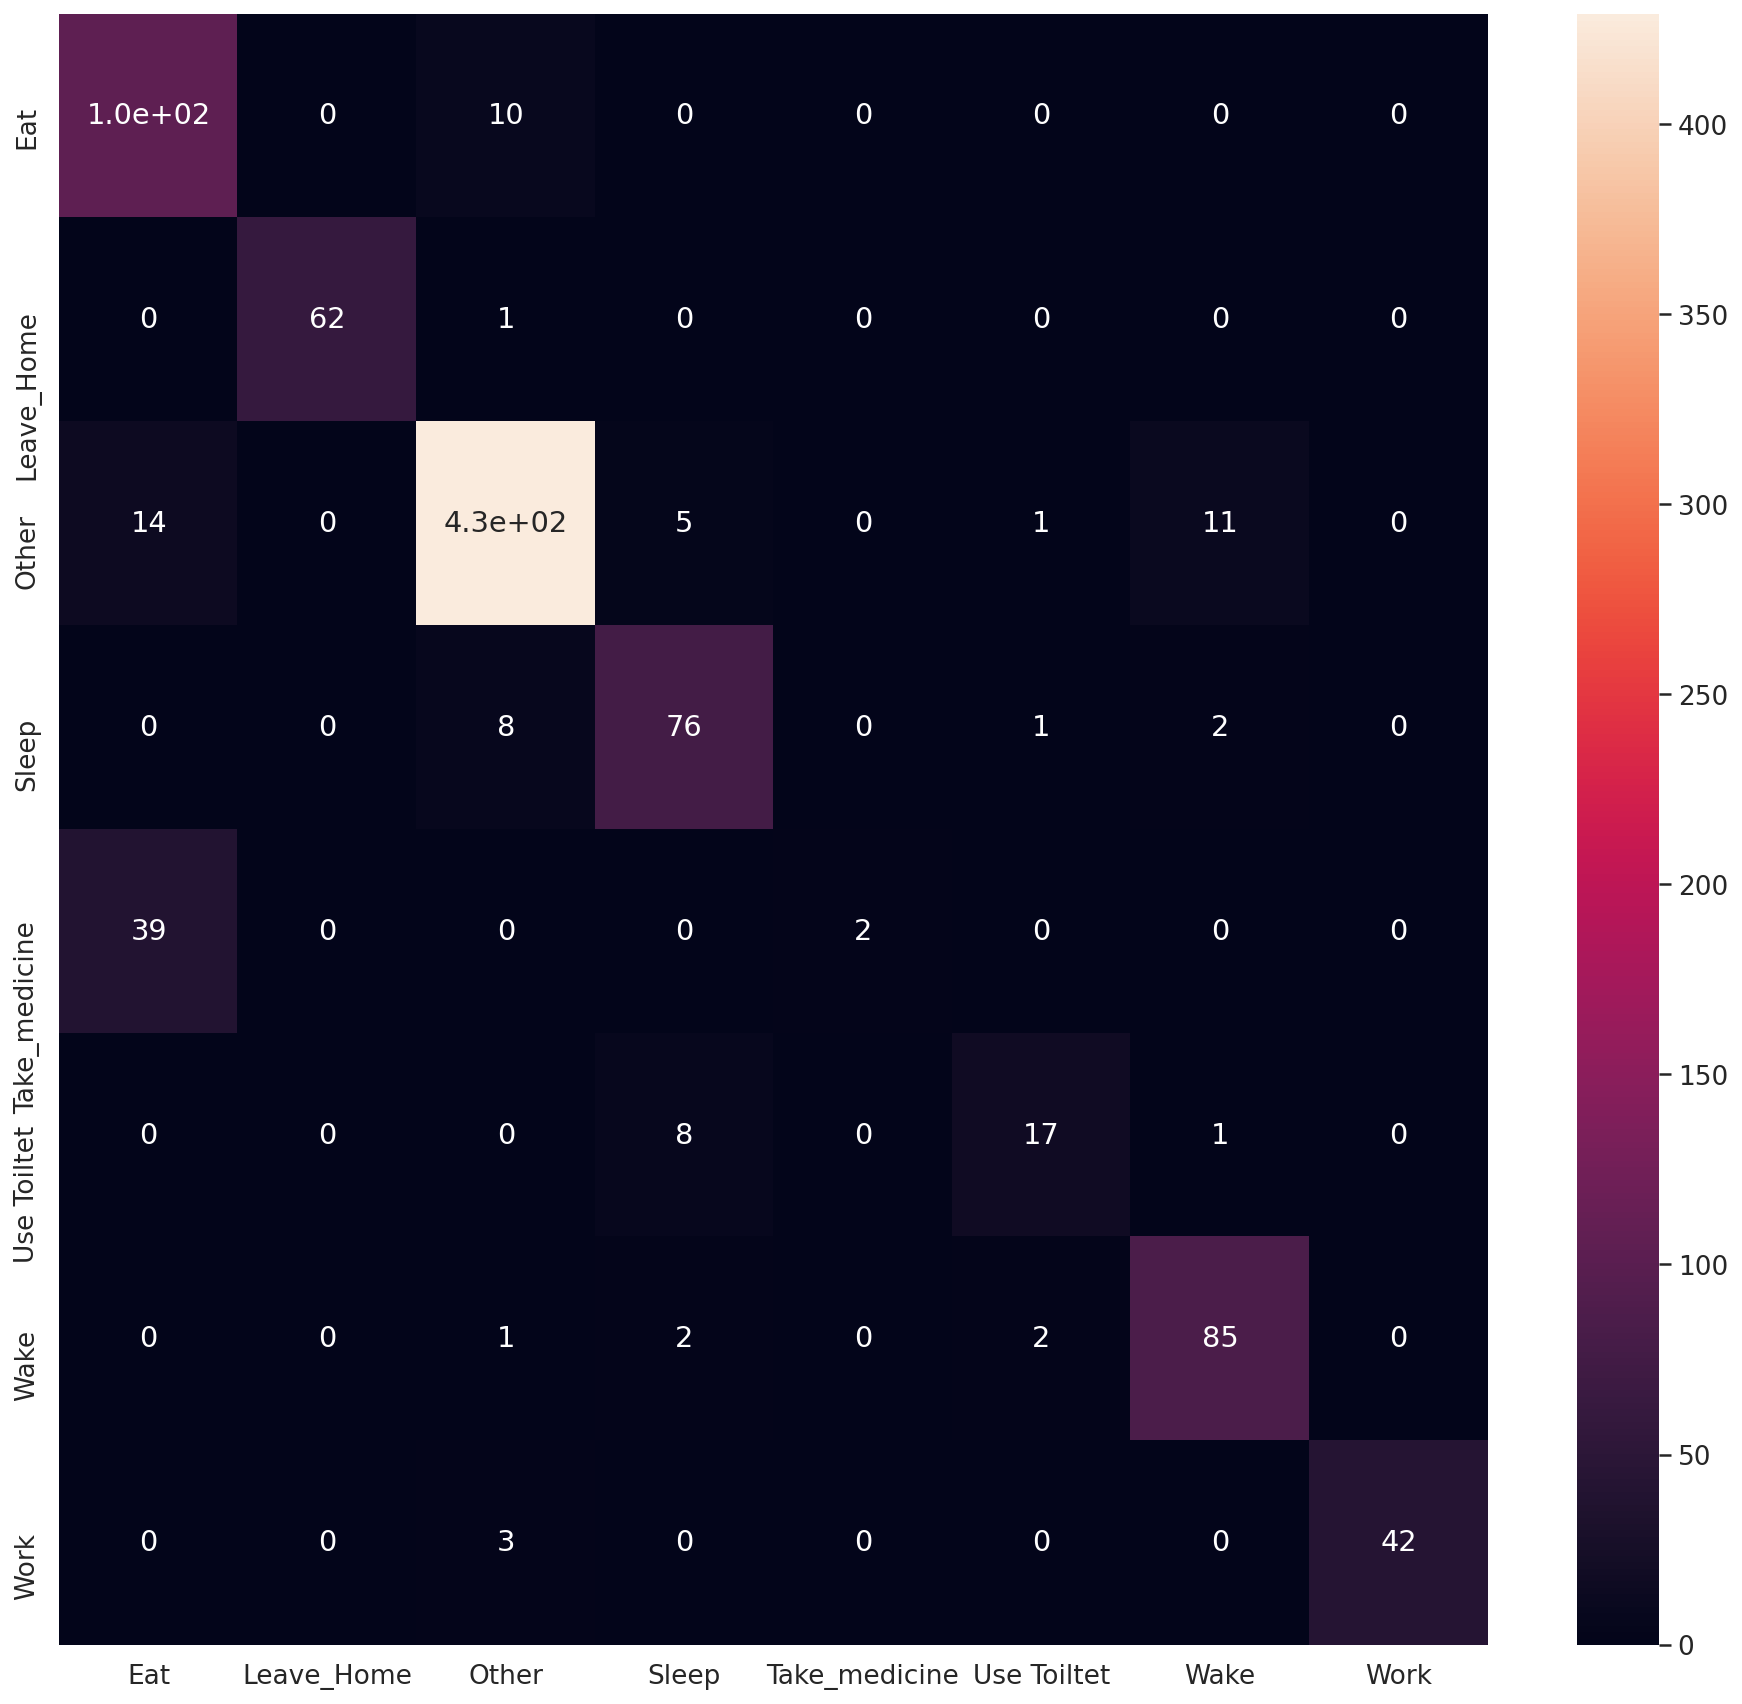

In [ ]:
fig, ax = plt.subplots(figsize=(16,15))
sns.heatmap(confusion_matrix(targets, preds), annot=True, ax=ax)
ax.set(xticklabels=idx2act, yticklabels=idx2act)


# TRAINING CYCLE2


In [ ]:
history2 = model.fit(X_tensor, Y_tensor, validation_split=0.2, batch_size=64, verbose=1, epochs=10, callbacks=[saveModel])

Epoch 1/10
12/12 [==============================] - 94s 8s/step - loss: 0.2624 - accuracy: 0.8920 - val_loss: 0.3999 - val_accuracy: 0.8333
Epoch 2/10
12/12 [==============================] - 94s 8s/step - loss: 0.2485 - accuracy: 0.9096 - val_loss: 0.3379 - val_accuracy: 0.8656
Epoch 3/10
12/12 [==============================] - 96s 8s/step - loss: 0.2405 - accuracy: 0.9163 - val_loss: 0.3595 - val_accuracy: 0.8656
Epoch 4/10
12/12 [==============================] - 94s 8s/step - loss: 0.2310 - accuracy: 0.9177 - val_loss: 0.3414 - val_accuracy: 0.8602
Epoch 5/10
12/12 [==============================] - 96s 8s/step - loss: 0.2276 - accuracy: 0.9204 - val_loss: 0.3387 - val_accuracy: 0.8495
Epoch 6/10
12/12 [==============================] - 94s 8s/step - loss: 0.2161 - accuracy: 0.9231 - val_loss: 0.3617 - val_accuracy: 0.8333
Epoch 7/10
12/12 [==============================] - 96s 8s/step - loss: 0.2110 - accuracy: 0.9285 - val_loss: 0.3158 - val_accuracy: 0.8656
Epoch 8/10
12/12 [==

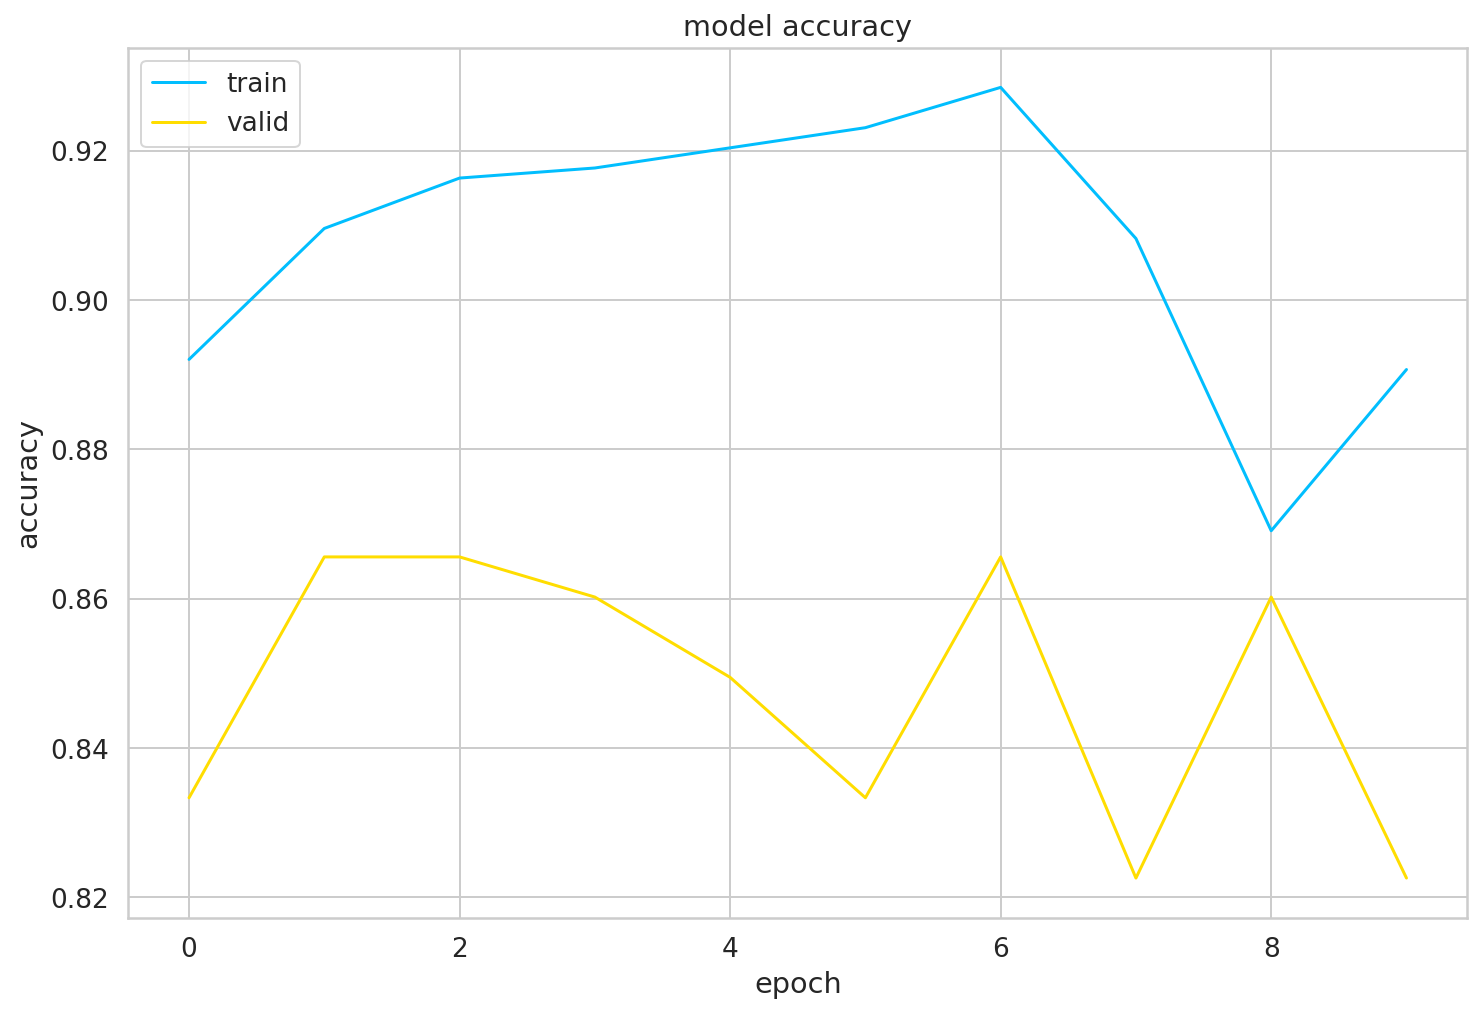

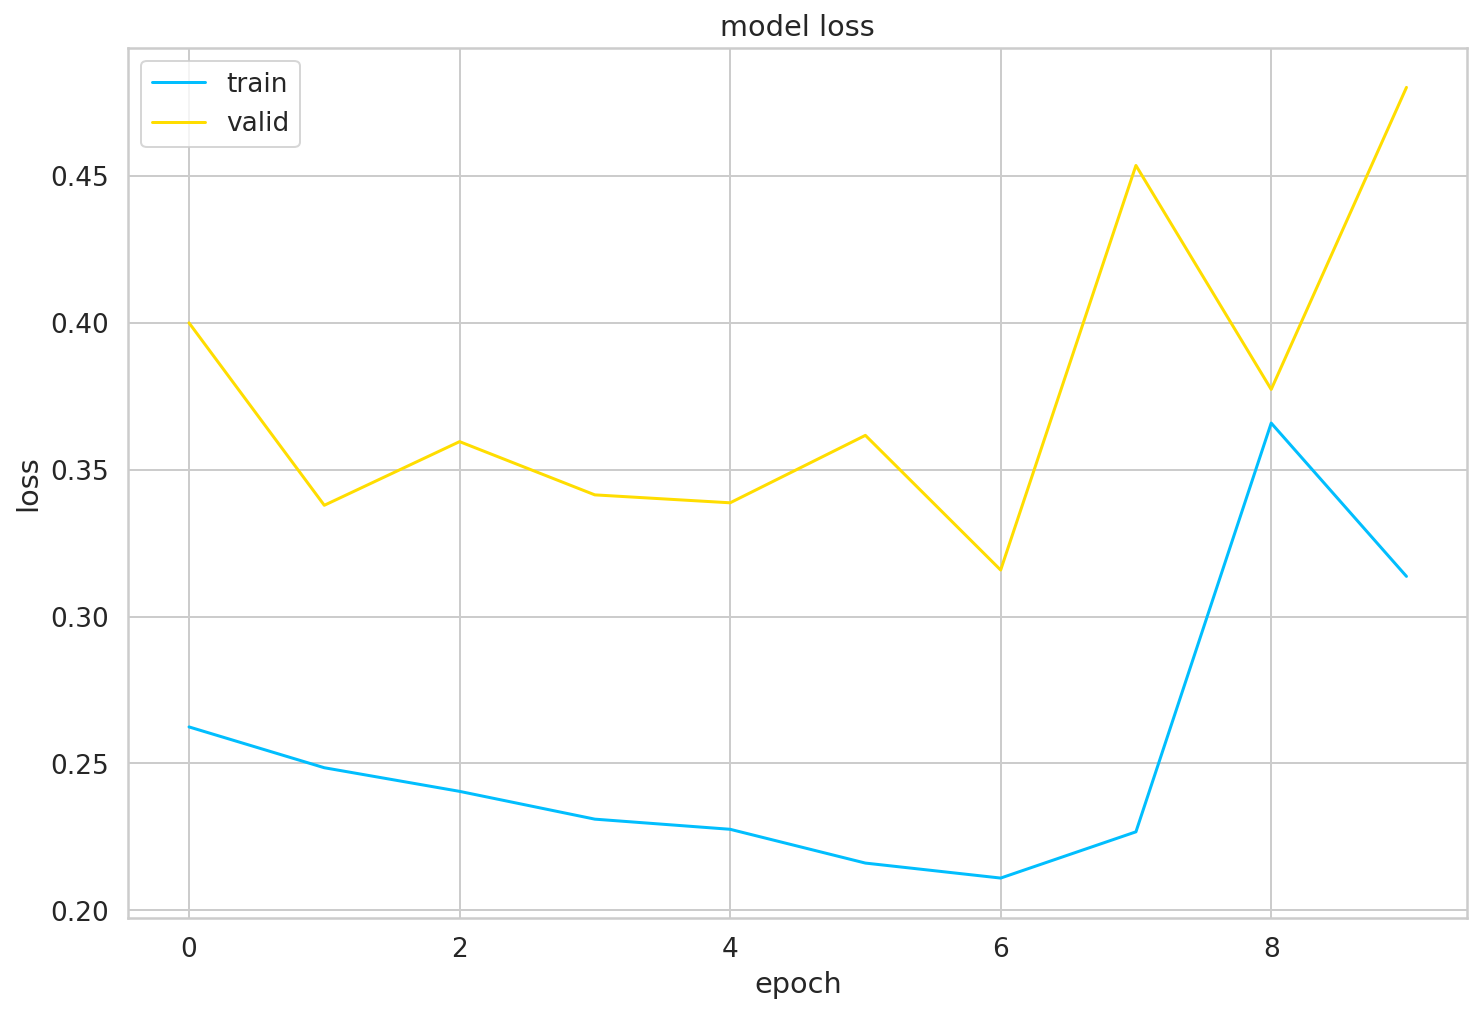

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# EVALUATION

In [ ]:
# class wise acc - training data
get_class_acc(X_tensor, Y_tensor, model, idx2act)

Eat : 78/84  [92.86 %]
Leave_Home : 62/65  [95.38 %]
Other : 418/448  [93.3 %]
Sleep : 79/102  [77.45 %]
Take_medicine : 35/60  [58.33 %]
Use Toiltet : 15/20  [75.0 %]
Wake : 85/112  [75.89 %]
Work : 43/44  [97.73 %]


In [ ]:
scores = model.evaluate(X_tensor_test, Y_tensor_test, batch_size=64, verbose=1)
print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))

2/2 [==============================] - 1s 488ms/step - loss: 0.5467 - accuracy: 0.8269
accuracy: 82.69%


In [ ]:
# class wise accuracy - test data
get_class_acc(X_tensor_test, Y_tensor_test, model, idx2act)

Eat : 9/9  [100.0 %]
Leave_Home : 7/7  [100.0 %]
Other : 48/51  [94.12 %]
Sleep : 11/17  [64.71 %]
Take_medicine : 3/6  [50.0 %]
Use Toiltet : 1/2  [50.0 %]
Wake : 8/13  [61.54 %]
Work : 7/7  [100.0 %]
